# Observation Planning for Radio Observations

This worksheet will introduce you to some concepts you'll need to plan out your observations with the radio telescope.

First, we are going to select our observatory.  We will use astroplan plus astropy coordinates.

Import them and confirm they're installed:

In [1]:
%pip install astroplan reproject

  Using cached astropy_healpix-1.0.3-cp39-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.4/989.4 kB 16.5 MB/s eta 0:00:00
Using cached astropy_healpix-1.0.3-cp39-abi3-macosx_11_0_arm64.whl (81 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from astropy import units as u
from astropy import coordinates
from astroplan import Observer

Next, we set up the observer.

We are going to pick the observer based on the known latitude and longitude of our observatory in Gainesville in [geodetic](https://en.wikipedia.org/wiki/Geographic_coordinate_system) coordinates, meaning we're specifying the location with two angles and one elevation (height above ellipsoid).

This will convert into some coordinate system used internally by astropy.

In [3]:
gainesville_location = coordinates.EarthLocation.from_geodetic(lon=-82.3*u.deg, lat=29.6*u.deg, height=100*u.m)
gainesville_location

<EarthLocation (743674.13504561, -5500332.52750589, 3131946.80724394) m>

We then set up the "observer", which will be used as our reference when looking at the sky.  We specify a time zone so we can use local times.

In [4]:
observer = Observer(gainesville_location, timezone='US/Eastern')
observer

<Observer: location (lon, lat, el)=(-82.30000000000001 deg, 29.600000000000005 deg, 100.0000000004584 m),
    timezone=<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>>

## Where are we pointed?

Now we can ask some questions: if we point at a specific altitude and azimuth, what's there now?  What's going to be there in 12 hours?

We define "now", but it requires more packages,  ``pytz`` = "python timezone":

In [5]:
import pytz
import datetime
now = pytz.timezone('US/Eastern').localize(datetime.datetime.now())
now

datetime.datetime(2024, 10, 23, 16, 8, 36, 394703, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

### Quick review

Before running the next cell, answer the following two questions (you can name an object or give a coordinate in RA/Dec or Galactic): 

What is at 90 degrees altitude?

**write in your answer here**

What is at 90 degrees altitude, 180 degrees azimuth?

**write in your answer here**


In [6]:
target = coordinates.SkyCoord(alt=90*u.deg, az=180*u.deg,
                              location=observer.location,
                              obstime=now,
                              frame='altaz').transform_to(coordinates.Galactic())
target

<SkyCoord (Galactic): (l, b) in deg
    (50.62894708, 38.19066876)>

The "target" variable is now a Galactic coordinate that tells us where we're pointing in the galaxy *right now*.

If we want to know the RA/Dec, we can convert it:

In [7]:
target.transform_to(coordinates.FK5())

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (252.34450435, 29.6407568)>

## Planning for future observations

What if we want to predict a future observation?

(specify time formats using https://docs.python.org/3/library/datetime.html)

In [8]:
time = datetime.datetime.strptime('January 1, 2023 4:30:00 AM', "%B %d, %Y %I:%M:%S %p",)
time

datetime.datetime(2023, 1, 1, 4, 30)

In [9]:
target = coordinates.SkyCoord(alt=90*u.deg, az=180*u.deg,
                              location=observer.location,
                              obstime=time,
                              frame='altaz').transform_to(coordinates.Galactic)
target

<SkyCoord (Galactic): (l, b) in deg
    (178.98636112, -0.40200946)>

You can also change your altitude and azimuth.

## Where is my target (where do I have to point)?

This is the fundamental question all observatories have to answer: given a target at a specific RA, Dec, where do we point?  What altitude and azimuth do we point at?

(the question is easier if you have an equatorial mount, but you still need to know what Right Ascension to point at)

You want to know, for the purpose of observing gas in our Galaxy: Where do I have to point to see the Galactic Plane?
If I want to observe the Galactic plane at different lines of longitude, then where do I have to point?

The Galactic Plane is simply the circle in Galactic coordinates where the latitude is zero degrees.

In [10]:
# we pick a target at Galactic longitude=45 degrees and latitute=0 (the Galactic midplane)
target = coordinates.SkyCoord(45*u.deg, 0*u.deg, frame='galactic')

In [11]:
altaz_of_target = observer.altaz(time=time, target=target)
altaz_of_target

<SkyCoord (AltAz: obstime=2023-01-01 04:30:00, location=(743674.1350456128, -5500332.527505894, 3131946.8072439414) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (327.87759726, -43.99067624)>

In [12]:
# print just the altitude
altaz_of_target.alt

<Latitude -43.99067624 deg>

Using the astroplan "observer", we can find the alt & az of our target at any time.  In the above example, the target has an altitude of -44 degrees: not observable!  

When can we see it?  Let's try 12 hours later...

In [13]:
time = datetime.datetime.strptime('January 1, 2023 4:30:00 PM', "%B %d, %Y %I:%M:%S %p",)
altaz_of_target2 = observer.altaz(time=time, target=target)
altaz_of_target2.alt

<Latitude 61.86537528 deg>

+61 degrees is observable

So if you have the question, "What will I see if I look at the sky right now?", you can answer it - convert alt/az to ra/dec or Galactic coordinates.

If you have the question, "When can I see my target?", you can answer it by converting target coordinates to alt/az at any given time.

Generally, though, you want to know a *range* of times.  Plots help with that.

Let's say we want to plot the observability over the course of a day.  We can use astropy's time for this:

In [14]:
from astropy.time import Time, TimeDelta
atime = Time(time)
atimes = atime + TimeDelta(1*u.h) * np.arange(24)
atimes

<Time object: scale='utc' format='datetime' value=[datetime.datetime(2023, 1, 1, 16, 30)
 datetime.datetime(2023, 1, 1, 17, 30)
 datetime.datetime(2023, 1, 1, 18, 30)
 datetime.datetime(2023, 1, 1, 19, 30)
 datetime.datetime(2023, 1, 1, 20, 30)
 datetime.datetime(2023, 1, 1, 21, 30)
 datetime.datetime(2023, 1, 1, 22, 30)
 datetime.datetime(2023, 1, 1, 23, 30)
 datetime.datetime(2023, 1, 2, 0, 30) datetime.datetime(2023, 1, 2, 1, 30)
 datetime.datetime(2023, 1, 2, 2, 30) datetime.datetime(2023, 1, 2, 3, 30)
 datetime.datetime(2023, 1, 2, 4, 30) datetime.datetime(2023, 1, 2, 5, 30)
 datetime.datetime(2023, 1, 2, 6, 30) datetime.datetime(2023, 1, 2, 7, 30)
 datetime.datetime(2023, 1, 2, 8, 30) datetime.datetime(2023, 1, 2, 9, 30)
 datetime.datetime(2023, 1, 2, 10, 30)
 datetime.datetime(2023, 1, 2, 11, 30)
 datetime.datetime(2023, 1, 2, 12, 30)
 datetime.datetime(2023, 1, 2, 13, 30)
 datetime.datetime(2023, 1, 2, 14, 30)
 datetime.datetime(2023, 1, 2, 15, 30)]>

We can then compute where our target will be (altitude, azimuth) vs time:

In [15]:
altaz = observer.altaz(atimes, target=target)
altaz

<SkyCoord (AltAz: obstime=[datetime.datetime(2023, 1, 1, 16, 30)
 datetime.datetime(2023, 1, 1, 17, 30)
 datetime.datetime(2023, 1, 1, 18, 30)
 datetime.datetime(2023, 1, 1, 19, 30)
 datetime.datetime(2023, 1, 1, 20, 30)
 datetime.datetime(2023, 1, 1, 21, 30)
 datetime.datetime(2023, 1, 1, 22, 30)
 datetime.datetime(2023, 1, 1, 23, 30)
 datetime.datetime(2023, 1, 2, 0, 30) datetime.datetime(2023, 1, 2, 1, 30)
 datetime.datetime(2023, 1, 2, 2, 30) datetime.datetime(2023, 1, 2, 3, 30)
 datetime.datetime(2023, 1, 2, 4, 30) datetime.datetime(2023, 1, 2, 5, 30)
 datetime.datetime(2023, 1, 2, 6, 30) datetime.datetime(2023, 1, 2, 7, 30)
 datetime.datetime(2023, 1, 2, 8, 30) datetime.datetime(2023, 1, 2, 9, 30)
 datetime.datetime(2023, 1, 2, 10, 30)
 datetime.datetime(2023, 1, 2, 11, 30)
 datetime.datetime(2023, 1, 2, 12, 30)
 datetime.datetime(2023, 1, 2, 13, 30)
 datetime.datetime(2023, 1, 2, 14, 30)
 datetime.datetime(2023, 1, 2, 15, 30)], location=(743674.1350456128, -5500332.527505894, 31

We can then plot it....

In [16]:
from astropy import visualization
import pylab as pl
visualization.quantity_support() # only need this once
pl.style.use('dark_background')

/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_72734/18937603.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  pl.subplot(1,2,1).plot_date(atimes.plot_date, altaz.alt)
/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_72734/18937603.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  pl.subplot(1,2,2).plot_date(atimes.plot_date, altaz.az)


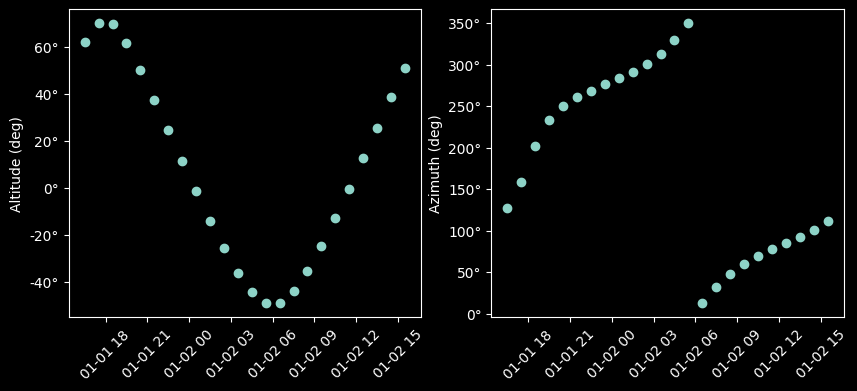

In [17]:
pl.figure(figsize=(10,4))
pl.subplot(1,2,1).plot_date(atimes.plot_date, altaz.alt)
pl.xticks(rotation=45)
pl.ylabel("Altitude (deg)")
pl.subplot(1,2,2).plot_date(atimes.plot_date, altaz.az)
pl.xticks(rotation=45)
pl.ylabel("Azimuth (deg)");

# Visualizing your plan

From the "Observation Planning to Map Making" lecture, you can grab an image of the Galaxy and overplot

In [18]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization import simple_norm

In [19]:
# first step: we need to download an all-sky image
# Use the ROSAT image to get an all-sky header
filename = get_pkg_data_filename('allsky/allsky_rosat.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
data = hdu.data

# let's also grab the HI data
from reproject import reproject_from_healpix, reproject_to_healpix
hihdu = fits.open('https://lambda.gsfc.nasa.gov/data/foregrounds/ebv_2017/mom0_-90_90_1024.hpx.fits')
hiarray, hifootprint = reproject_from_healpix(hihdu[1], hdu.header)

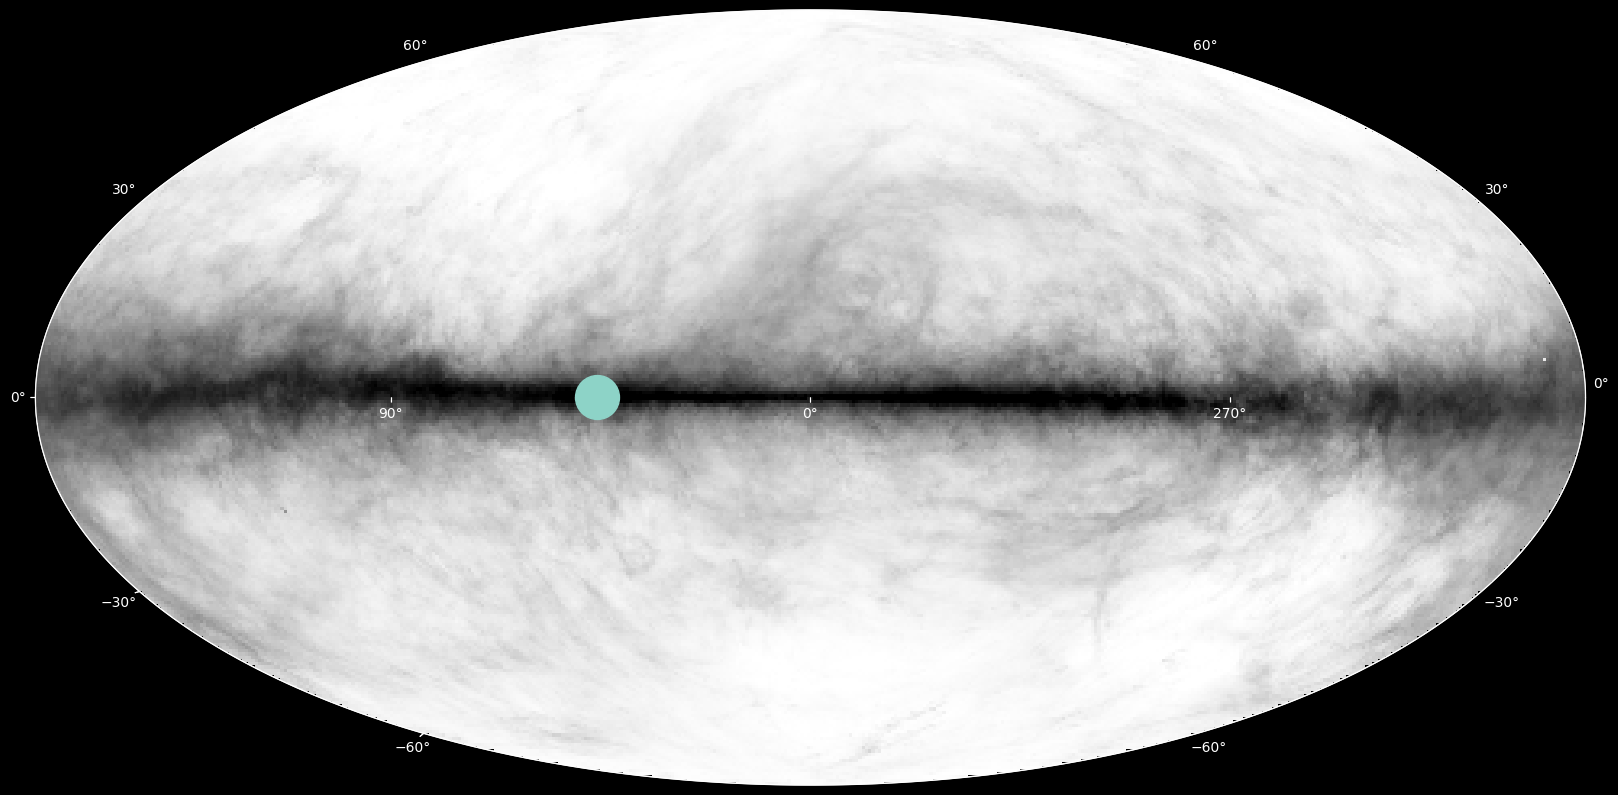

In [20]:
# next, make the figure with special attributes
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(hiarray, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(hiarray, stretch='asinh', max_percent=99.5, min_percent=1))

# and overplot a location
ax.scatter(target.galactic.l, target.galactic.b, s=1000, transform=ax.get_transform('galactic'));

## EXERCISE:

Repeat the above for three locations in the Galactic plane.

Try l=0, l=90, and l=135 degrees.

Can you observe all three locations in the same observing session?